In [77]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'UCY/NLP/AirBnB_project'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
ROOT_PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)
sys.path.append(ROOT_PATH)
%cd /content/drive/My\ Drive/$FOLDERNAME/

SUBMODULES = ['processing', 'utils', 'Dataset']

import sys
for module in SUBMODULES:
  sys.path.append('/content/drive/My Drive/{}/{}'.format(FOLDERNAME, module))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/UCY/NLP/AirBnB_project


In [2]:
!pip install transformers sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn

from amenities import AmenitiesClustering
from transformers import BertTokenizer, BertModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split

import pickle




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# os.getcwd()
# os.chdir('C:/Users/frlan/Documents/NLP/dataset')

# change the path to C:\Users\Kyriakos\Desktop\MsC AI\NLP\NLP AirBNB Project\AirBnB_score_prediction\dataset
# os.chdir('C:\\Users\\Kyriakos\\Desktop\\MsC AI\\NLP\\NLP AirBNB Project\\AirBnB_score_prediction\\dataset')
# os.getcwd()

In [5]:
# import label_encoder to use it for the categorical features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [86]:
# 'listings_comments.csv is the datset compined 

# reaf the datset from Google Drive G:\.shortcut-targets-by-id\1CZZx9Bpz7hB-BhPFsqAL3fRVyxM1XfwF\AirBnB_project
# data = pd.read_csv('G:\\.shortcut-targets-by-id\\1CZZx9Bpz7hB-BhPFsqAL3fRVyxM1XfwF\\AirBnB_project\\listings_comments.csv')
DATASET_PATH = f'{ROOT_PATH}/Dataset'
from dataloader import Dataloader
data = Dataloader(
    listing_path = f'{DATASET_PATH}/listings',
    comments_path = f'{DATASET_PATH}/comments',
)
data = data.getListings()



In [7]:
data.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.sample(2)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1134,8551630,https://www.airbnb.com/rooms/8551630,20230309202119,2023-03-10,city scrape,"Luxurious apartment, great location",Beautiful and recently redecorated apartment n...,Our apartment is centrally located and conside...,https://a0.muscache.com/pictures/f4142845-ee9e...,10496065,https://www.airbnb.com/users/show/10496065,Melissa & Douwe,2013-12-08,"Amsterdam, Netherlands","We are a Dutch - Colombian family, living in t...",within a day,100%,75%,f,https://a0.muscache.com/im/pictures/user/c7e17...,https://a0.muscache.com/im/pictures/user/c7e17...,NaN,2,2,"['email', 'phone']",t,t,"Amsterdam, North Holland, Netherlands",De Baarsjes - Oud-West,NaN,52.36456,4.87494,Entire condo,Entire home/apt,4,NaN,1 bath,2.0,2.0,"[""Drying rack for clothing"", ""Bluetooth sound ...",$439.00,3,14,3,3,14,14,3.0,14.0,NaN,t,4,7,7,7,2023-03-10,40,6,0,2016-03-30,2023-01-23,4.98,4.98,4.95,4.97,4.97,4.92,4.69,0363 D67C 5FDF D7F8 9B41,f,1,1,0,0,0.47
1602,14246224,https://www.airbnb.com/rooms/14246224,20230309202119,2023-03-10,previous scrape,Comfortable & cozy apartment,"Cozy, beautiful and renovated apartment in the...",Bos en Lommer is a diverse and family-orientat...,https://a0.muscache.com/pictures/fc50d486-9e0b...,13178305,https://www.airbnb.com/users/show/13178305,Lars,2014-03-16,"Amsterdam, Netherlands",NaN,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/user/c528b...,https://a0.muscache.com/im/pictures/user/c528b...,NaN,1,1,"['email', 'phone']",t,t,"Amsterdam, Noord-Holland, Netherlands",Bos en Lommer,NaN,52.37866,4.85368,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Wifi"", ""Washer"", ""Hair dryer"", ""Bed linens"",...",$150.00,2,1125,2,2,1125,1125,2.0,1125.0,NaN,t,0,0,0,0,2023-03-10,7,0,0,2016-08-07,2020-03-06,5.00,4.86,5.00,5.00,5.00,5.00,4.83,0363 CB5E 0600 97E0 D889,f,1,1,0,0,0.09


# Base Preperation

## Remove unnecessary columns

In [9]:
len(data.columns)

75

In [10]:
# Crate a list for removing unnecessary columns from the dataset
ignored_conlumns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source','picture_url', 'host_id',
       'host_url','host_name','host_location','host_thumbnail_url', 'host_picture_url','host_verifications','neighbourhood_group_cleansed','latitude',
       'longitude','bathrooms','calendar_updated','has_availability','availability_30', 'availability_60', 'availability_90',
       'availability_365','calendar_last_scraped', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','instant_bookable',
       'calculated_host_listings_count','license']

In [81]:
# Remove the unnecessary columns from the dataset.
data.drop(ignored_conlumns, axis=1, inplace=True)
len(data.columns)

41

## Check and replace nan values


In [12]:
def fill_nan(df, column):
    if(df[column].astype(str).str.isnumeric().all()==True):
        #Numeric values
        df[column].fillna(df[column].mean(), inplace=True)
    else:
        #string balue
        df[column].fillna('UNK', inplace=True)

    return df

for columnName in data.columns:
    data = fill_nan(data, columnName)

# Column processing

## Function that takes a column and returns an embeddings matrix

In [13]:
# Check the number of unique values in each column
data.nunique()


name                                            6903
description                                     6894
neighborhood_overview                           4136
host_since                                      2734
host_about                                      3378
host_response_time                                 5
host_response_rate                                57
host_acceptance_rate                              97
host_is_superhost                                  3
host_neighbourhood                                58
host_listings_count                               30
host_total_listings_count                         45
host_has_profile_pic                               2
host_identity_verified                             2
neighbourhood                                     51
neighbourhood_cleansed                            22
property_type                                     58
room_type                                          4
accommodates                                  

In [14]:
# load the model that is responsible for the text embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# create a device object
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
# move the model to the device
model.to(device)

# parallelize the model across multiple GPUs(if available)
model = nn.DataParallel(model)

underlying_model = model.module

Device: cuda


In [15]:
# function to get the embeddings for a column in a dataframe and return them as a numpy array
def get_embeddings(dataframe, column_name, batch_size=100):
    """
    Obtain sentence embeddings for a dataframe column using SentenceTransformer with batch processing.

    Args:
        dataframe (pandas.DataFrame): The dataframe containing the column to obtain embeddings for.
        column_name (str): The name of the column to obtain embeddings for.
        batch_size (int, optional): The size of each batch to process. Default is 100.

    Returns:
        numpy.ndarray: A numpy array containing the embeddings for the specified column.
    """

    # Obtain the embeddings for the specified column in batches
    num_batches = int(np.ceil(len(dataframe) / batch_size))
    embeddings = []
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min(start_index + batch_size, len(dataframe))
        batch_embeddings = model.encode(dataframe[column_name][start_index:end_index].tolist())
        embeddings.append(batch_embeddings)
    embeddings = np.concatenate(embeddings)

    return embeddings

In [16]:
processedColumns = pd.DataFrame()

## Text Columns - word embedings

For columns that have text values in them we have decided to embed the text using the following model: SentenceTransformer('all-MiniLM-L6-v2')

From that model we recieved teh word emebdings which are then placed into teh data frame for later use in the PCA analysis.
In this case we decided to keep the embedding conlums separated


### neighborhood_overview

In [17]:
#Get the word encodings for the text in the column
neighborhood_overview_embeddings = underlying_model.encode(data.neighborhood_overview.values)


In [18]:
# Convert embeddings to a DataFrame with string column names
processedColumnsNeighborhoodOverview = pd.DataFrame(neighborhood_overview_embeddings, columns=[f'neighborhood_overview_embeddings{i+1}' for i in range(neighborhood_overview_embeddings.shape[1])])

### host_about

In [19]:
#Get the word encodings for the text in the column
host_about_embeddings = underlying_model.encode(data.host_about)

In [20]:
# Convert embeddings to a DataFrame with string column names
processedColumnsHostAbout = pd.DataFrame(host_about_embeddings, columns=[f'host_about_embeddings{i+1}' for i in range(host_about_embeddings.shape[1])])

### name

In [21]:
#Get the word encodings for the text in the column
name_embeddings = underlying_model.encode(data.name)

In [22]:
# Convert embeddings to a DataFrame with string column names
processedColumnsName = pd.DataFrame(name_embeddings, columns=[f'name_embeddings{i+1}' for i in range(name_embeddings.shape[1])])

### description

In [23]:
#Get the word encodings for the text in the column
description_embeddings = underlying_model.encode(data.description)

In [24]:
# Convert embeddings to a DataFrame with string column names
processedColumnsDescription = pd.DataFrame(description_embeddings, columns=[f'description_embeddings{i+1}' for i in range(description_embeddings.shape[1])])

### bathroom_text

In [25]:
data.bathrooms_text.sample(5)

4591    1 private bath
3799         1.5 baths
6006            1 bath
2867            1 bath
5900         1.5 baths
Name: bathrooms_text, dtype: object

In [26]:
import re

def extract_number(string):
    pattern = r'^(\d+(?:\.\d+)?)' # regular expression pattern to match the number at the start of the string
    match = re.match(pattern, string)
    if match:
        return float(match.group(1))
    else:
        return None
#Extract the number of bathrooms from the text example: 1.2 bathrooms > 1.2
numberOfBathrooms = data.bathrooms_text.apply(extract_number)
numberOfBathrooms.sample(5)

5362    1.0
226     3.5
580     NaN
6858    1.0
633     1.5
Name: bathrooms_text, dtype: float64

In [27]:
processedColumns['bathrooms_text']=numberOfBathrooms
processedColumns.sample(5).bathrooms_text

6951    1.5
611     2.5
4019    1.0
4092    1.5
1750    1.5
Name: bathrooms_text, dtype: float64

### price

In [28]:
data.price.sample(5)

5812     $50.00
3818     $74.00
3145     $79.00
6033    $194.00
1819    $128.00
Name: price, dtype: object

In [29]:
processedColumns['price'] = data.price.apply(lambda p: float(p.replace("$", "").replace(",", "")))


## Categorical Columns - label encoding

For columns that have categorical columns we have decided to label encde them using the function le.fit_transform() using the LabelEncoder class from sklearn.preprocessing.

Outputs of the label encoding we saved in the processedColumns dataframe which we then later used in PCA analysis.

### host_response_time

In [30]:
#Get the label encoding for the categorical column
encoding = le.fit_transform(data.host_response_time)


In [31]:
# Save the label encoding into the main pandas dataframe for later processing
processedColumns['host_response_time']=encoding
processedColumns.sample(5)

,bathrooms_text,price,host_response_time
1465,1.0,225.0,3
626,1.0,159.0,0
866,2.0,144.0,4
3968,1.0,180.0,4
6809,1.0,275.0,2


### host_response_rate

In [32]:
processedColumns['host_response_rate'] = data.host_response_rate.apply(lambda rt: 0.0 if pd.isnull(rt) or rt=='UNK' else float(rt.replace("%", "")))
processedColumns.sample(5)

,bathrooms_text,price,host_response_time,host_response_rate
4824,1.5,150.0,3,95.0
1204,1.5,116.0,4,100.0
3073,1.0,242.0,4,100.0
1867,1.0,169.0,4,100.0
3279,1.0,240.0,0,0.0


### host_acceptance_rate

In [33]:
processedColumns['host_acceptance_rate']= data.host_acceptance_rate.apply(lambda rt: 0.0 if pd.isnull(rt) or rt=='UNK' else float(rt.replace("%", "")))
processedColumns.sample(5)

,bathrooms_text,price,host_response_time,host_response_rate,host_acceptance_rate
5424,2.5,750.0,0,0.0,0.0
1931,1.5,218.0,3,100.0,83.0
1898,1.0,126.0,4,100.0,100.0
6608,1.0,294.0,3,100.0,88.0
808,1.0,169.0,0,0.0,100.0


### host_is_superhost

In [34]:
encoding = le.fit_transform(data.host_is_superhost)

In [35]:
processedColumns['host_is_superhost']=encoding
processedColumns.sample(5).host_is_superhost

2999    1
4074    1
4818    1
1674    1
996     2
Name: host_is_superhost, dtype: int64

### host_neighbourhood

In [36]:
data.host_neighbourhood.value_counts()

UNK                                    4022
Oud-West                                553
Grachtengordel                          244
De Pijp                                 234
Jordaan                                 189
Oosterparkbuurt                         157
Bos en Lommer                           126
Indische Buurt                          116
Oost                                     84
Nieuwmarkt en Lastage                    79
Rivierenbuurt                            78
Hoofddorppleinbuurt                      69
Watergraafsmeer                          64
De Wallen                                62
Westelijke Eilanden                      57
Oostelijke Eilanden en Kadijken          57
Amsterdam Centrum                        56
Weesperbuurt en Plantage                 55
Frederik Hendrikbuurt                    53
Zeeburg                                  52
Oud-Zuid                                 50
Stadionbuurt                             45
Spaarndammer en Zeeheldenbuurt  

In [37]:
vc = data.host_neighbourhood.value_counts()
single_neighborhoods = vc[vc == 1].index.tolist()

data.loc[data['host_neighbourhood'].isin(single_neighborhoods), 'host_neighbourhood'] = 'other'

single_neighborhoods

['LB of Islington',
 'Grand Place',
 'Merkaz HaIr',
 'Belváros',
 'Sant Antoni',
 'Stockwell',
 'El Raval',
 'La Combe',
 'Nieuwendammerham',
 'La Sagrada Família',
 'Palermo Hollywood',
 'Cannaregio',
 'Urbanización Galera la III']

In [38]:
data.host_neighbourhood.value_counts().tail(5)

Landelijk Noord                        11
Tuindorp Nieuwendam                     8
Buitenveldert-Oost                      6
Glòries - El Parc                       6
Nieuwendammerdijk en Buiksloterdijk     4
Name: host_neighbourhood, dtype: int64

In [39]:
encoding = le.fit_transform(data.host_neighbourhood)
processedColumns['host_neighbourhood']=encoding
processedColumns.host_neighbourhood

0       14
1       15
2        7
3        7
4       27
5       24
6       11
7       22
8       27
9        0
10      11
11      43
12       0
13      27
14       0
15      23
16      21
17      11
18      39
19      41
20      23
21      44
22      11
23      11
24      11
25      27
26      28
27      44
28      27
29      27
30      21
31       0
32      18
33      39
34      14
35      33
36      27
37      11
38      15
39       7
40      18
41      11
42      33
43       7
44      39
45      14
46      11
47      28
48      27
49      11
50      27
51      15
52      30
53       2
54      27
55       0
56      34
57      41
58      27
59       7
60      27
61       8
62       6
63       0
64      39
65      21
66      35
67      11
68      11
69      34
70      39
71      27
72      40
73      23
74      21
75      27
76      41
77      12
78      15
79      27
80      28
81      43
82      39
83      22
84      27
85      12
86       2
87      43
88       7
89      18
90      39

### host_has_profile_pic

In [40]:
encoding = le.fit_transform(data.host_has_profile_pic)
processedColumns['host_has_profile_pic']=encoding
processedColumns.sample(5).host_has_profile_pic

2460    1
2912    1
4314    1
1254    1
2309    1
Name: host_has_profile_pic, dtype: int64

### host_identity_verified

In [41]:
encoding = le.fit_transform(data.host_identity_verified)
processedColumns['host_identity_verified']=encoding
processedColumns.sample(5).host_identity_verified

5447    1
4627    1
5205    1
5857    1
1020    1
Name: host_identity_verified, dtype: int64

### neighbourhood_cleansed

In [42]:
data.neighbourhood_cleansed.value_counts().tail(5)

De Aker - Nieuw Sloten    49
Bijlmer-Centrum           44
Gaasperdam - Driemond     44
Osdorp                    43
Bijlmer-Oost              28
Name: neighbourhood_cleansed, dtype: int64

In [43]:
encoding = le.fit_transform(data.neighbourhood_cleansed)
processedColumns['neighbourhood_cleansed']=encoding
processedColumns.sample(5).neighbourhood_cleansed

4811     2
4464    20
6398     7
3129     5
1444     2
Name: neighbourhood_cleansed, dtype: int64

### property_type

In [44]:
encoding = le.fit_transform(data.property_type)
processedColumns['property_type']=encoding
processedColumns.sample(5).property_type

5776     7
5453     7
784     36
4869    12
3417    14
Name: property_type, dtype: int64

### room_type

In [45]:
encoding = le.fit_transform(data.room_type)
processedColumns['room_type']=encoding
processedColumns.sample(5).room_type

3916    0
3714    0
621     0
5489    0
6077    2
Name: room_type, dtype: int64

## Numerical/date Columns - converted to regular numbers

Columns that already have numerical values did not need any encoding here we only checked if any values are type of string "UNK" if so we replaced it. Besides just numbers we also processed date columns and replace the date with a time value which is in number format.

### host_since

In [46]:
from datetime import date
from datetime import datetime

#Get the dates from the dataframe
datetest =data.host_since.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

#Convert dates to number
time = datetest.apply(lambda x: x.toordinal())

#Save the number to the data frame
processedColumns['host_since']= pd.Series(time.tolist())

#Print the change
processedColumns.sample(5).host_since

120     736759
5337    736310
4859    735412
5600    736066
2379    735840
Name: host_since, dtype: int64

### host_listings_count

In [47]:
#Save the number that doesnt need to be changed into the processed columns dataframe for later processing
processedColumns['host_listings_count']= data.host_listings_count
processedColumns.sample(5).host_listings_count

2985    1
5740    1
1181    1
2609    1
2977    1
Name: host_listings_count, dtype: int64

### bedrooms

In [48]:
#Replace any occurances of "UNK" with number 0 since all values have to be int for PCA
withoutNa = data.bedrooms.replace("UNK",0)

#Make sure all values are type of float
processedColumns["bedrooms"]=withoutNa.astype(float)

#Vizualize
processedColumns.sample(5).bedrooms

952     1.0
1047    1.0
4115    2.0
4238    1.0
5007    2.0
Name: bedrooms, dtype: float64

### beds

In [49]:
#Replace any occurances of "UNK" with number 0 since all values have to be int for PCA
withoutNa=data.beds.replace('UNK', 0)

#Make sure all values are of type float
processedColumns["beds"]=withoutNa.astype(float)

#Vizualize
processedColumns.sample(5).beds

434     4.0
3803    2.0
2837    1.0
5896    1.0
4264    4.0
Name: beds, dtype: float64

### host_total_listings_count

In [50]:

processedColumns['host_total_listings_count']= data.host_total_listings_count
processedColumns.sample(5).host_total_listings_count

6065    1
4118    4
6145    1
3800    1
61      1
Name: host_total_listings_count, dtype: int64

### accommodates

In [51]:
processedColumns['accommodates']= data.accommodates
processedColumns.sample(5).accommodates

6729    2
477     2
6753    4
6473    2
5084    7
Name: accommodates, dtype: int64

### minimum_nights

In [52]:
processedColumns['minimum_nights']= data.minimum_nights
processedColumns.sample(5).minimum_nights

6692      2
3760      3
6874      3
6641      1
2149    500
Name: minimum_nights, dtype: int64

### maximum_nights

In [53]:
processedColumns['maximum_nights']= data.maximum_nights
processedColumns.sample(5).maximum_nights

1532       7
1481      10
1317    1125
5734      29
2961      60
Name: maximum_nights, dtype: int64

### minimum_minimum_nights

In [54]:
processedColumns['minimum_minimum_nights']= data.minimum_minimum_nights
processedColumns.sample(5).minimum_minimum_nights

5727    3
68      5
1916    3
5079    4
5305    1
Name: minimum_minimum_nights, dtype: int64

### maximum_minimum_nights

In [55]:
processedColumns['maximum_minimum_nights']= data.maximum_minimum_nights
processedColumns.sample(5).maximum_minimum_nights

5209    2
4960    7
1104    5
1466    2
2611    2
Name: maximum_minimum_nights, dtype: int64

### minimum_maximum_nights

In [56]:
processedColumns['minimum_maximum_nights']= data.minimum_maximum_nights
processedColumns.sample(5).minimum_maximum_nights

6188    1125
4947     999
6567     365
3928    1125
5285      30
Name: minimum_maximum_nights, dtype: int64

### maximum_maximum_nights

In [57]:
processedColumns['maximum_maximum_nights']= data.maximum_maximum_nights
processedColumns.sample(5).maximum_maximum_nights

2439      14
673     1125
2247    1125
4496    1125
6770    1125
Name: maximum_maximum_nights, dtype: int64

### minimum_nights_avg_ntm

In [58]:
processedColumns['minimum_nights_avg_ntm']= data.minimum_nights_avg_ntm
processedColumns.sample(5).minimum_nights_avg_ntm

3926     5.0
445      3.0
5101    30.0
1938     3.0
6569     1.3
Name: minimum_nights_avg_ntm, dtype: float64

### maximum_nights_avg_ntm

In [59]:
processedColumns['maximum_nights_avg_ntm']= data.maximum_nights_avg_ntm
processedColumns.sample(5).maximum_nights_avg_ntm

3625      10.0
1568    1125.0
1104    1125.0
3041      22.0
1116      15.0
Name: maximum_nights_avg_ntm, dtype: float64

### number_of_reviews

In [60]:
processedColumns['number_of_reviews']= data.number_of_reviews
processedColumns.sample(5).number_of_reviews

148     10
2565    15
3570     8
3432    27
614     42
Name: number_of_reviews, dtype: int64

### number_of_reviews_l30d

In [61]:
processedColumns['number_of_reviews_l30d']= data.number_of_reviews_l30d
processedColumns.sample(5).number_of_reviews_l30d

5031    0
2189    0
690     1
101     0
857     0
Name: number_of_reviews_l30d, dtype: int64

### first_review

In [62]:
data.first_review.sample(5)

1071    2015-09-14
6868           UNK
5546    2022-11-13
5155    2022-01-03
5729    2022-09-23
Name: first_review, dtype: object

In [63]:
timeData = data['first_review'].apply(lambda x: pd.Timestamp(x).toordinal() if x != 'UNK' else 0)
processedColumns['first_review']= pd.Series(timeData.tolist())
processedColumns.sample(5).first_review

5421    738304
4300    737721
5568    738346
4891    738081
5915    738381
Name: first_review, dtype: int64

### last_review


In [64]:
timeData = data['last_review'].apply(lambda x: pd.Timestamp(x).toordinal() if x != 'UNK' else 0)
processedColumns['last_review']= pd.Series(timeData.tolist())
processedColumns.sample(5).last_review

995     738409
6447    738488
6658         0
1975    738576
6355         0
Name: last_review, dtype: int64

### calculated_host_listings_count_entire_homes

In [65]:
processedColumns['calculated_host_listings_count_entire_homes']= data.calculated_host_listings_count_entire_homes
processedColumns.sample(5).calculated_host_listings_count_entire_homes

2461    1
5394    1
5807    1
5507    1
5201    1
Name: calculated_host_listings_count_entire_homes, dtype: int64

### calculated_host_listings_count_private_rooms

In [66]:
processedColumns['calculated_host_listings_count_private_rooms']= data.calculated_host_listings_count_private_rooms
processedColumns.sample(5).calculated_host_listings_count_private_rooms

4422    10
4066     0
3569     0
1060     0
6336     0
Name: calculated_host_listings_count_private_rooms, dtype: int64

### calculated_host_listings_count_shared_rooms

In [67]:
processedColumns['calculated_host_listings_count_shared_rooms']= data.calculated_host_listings_count_shared_rooms
processedColumns.sample(5).calculated_host_listings_count_shared_rooms

1421    0
5158    0
4313    0
5803    0
2247    0
Name: calculated_host_listings_count_shared_rooms, dtype: int64

### reviews_per_month

In [68]:
withoutUNK = data.reviews_per_month.replace('UNK', 0)
processedColumns['reviews_per_month']= withoutUNK.astype(float)
processedColumns.sample(5).reviews_per_month

1821    0.57
5538    0.75
6577    3.64
3961    0.15
1174    1.29
Name: reviews_per_month, dtype: float64

## Amenities

In [ ]:
amenitiesClusteringModel = AmenitiesClustering()
amenity_presences = amenitiesClusteringModel.fit_transform(data)
amenity_presences_conlumns = pd.DataFrame(amenity_presences, columns=[f'amenity_{i+1}' for i in range(len(amenity_presences[0]))])
processedColumns = pd.concat([processedColumns, amenity_presences_conlumns], axis=1)


## Saving results

In [75]:
# Pickle embedded text fields
with open('listing_name_embeddings.pkl', 'wb') as f:
    pickle.dump(processedColumnsName, f)

with open('listing_description_embeddings.pkl', 'wb') as f:
     pickle.dump(processedColumnsDescription, f)

with open('listing_host_about_embeddings.pkl', 'wb') as f:
    pickle.dump(processedColumnsHostAbout, f)

with open('listing_neighborhood_overview_embeddings.pkl', 'wb') as f:
    pickle.dump(processedColumnsNeighborhoodOverview, f)

# other fields
with open('listing_processed_data.pkl', 'wb') as f:
    pickle.dump(processedColumns, f)


# PCA

PCA Analysis is done on the processedColumns data frame. Before performing PCA we made sure that there are no NA values and we also scaled the data before using.

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#processedColumns.dropna(inplace=True)

# Convert column names to strings
processedColumns.columns = processedColumns.columns.astype(str)

# instantiate a StandardScaler object
scaler = StandardScaler()

# scale the data
scaled_processedColumns = scaler.fit_transform(processedColumns)

# Create a PCA object with 2 components
pca = PCA(n_components=2)

# Fit and transform the data to 2 principal components
principal_components = pca.fit_transform(scaled_processedColumns)

# Convert principal components to a DataFrame with string column names
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Concatenate the principal components with the original data
result_df = pd.concat([principal_df, processedColumns], axis=1)

# Print the explained variance ratio of the 2 components
print(pca.explained_variance_ratio_)
print("___")
print(principal_df)

# Vizualization

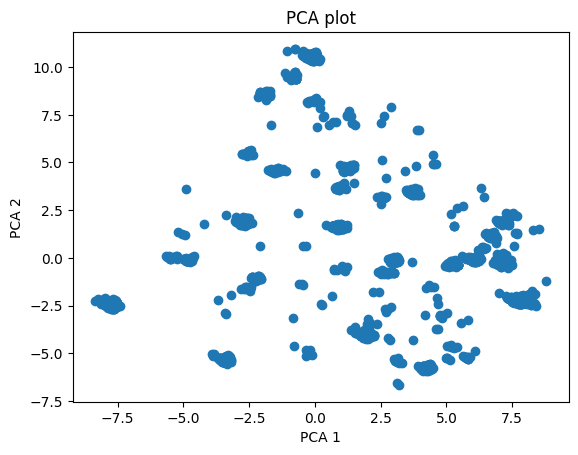

In [93]:
import matplotlib.pyplot as plt

# Plot PCA data
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA plot')
plt.show()

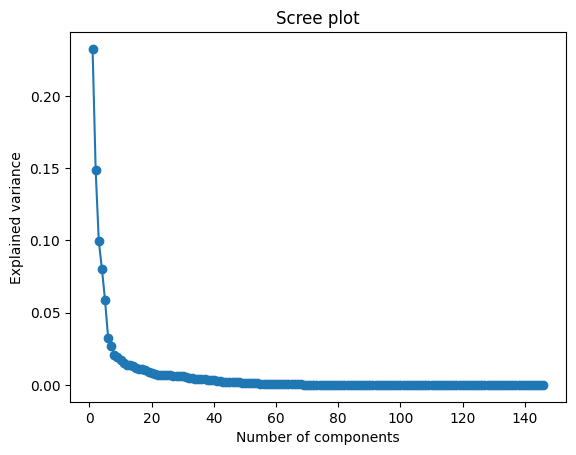

In [94]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# Initialize PCA model
pca = PCA()

# Fit data
pca.fit(scaled_processedColumns)

# Scree plot
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Scree plot')
plt.show()


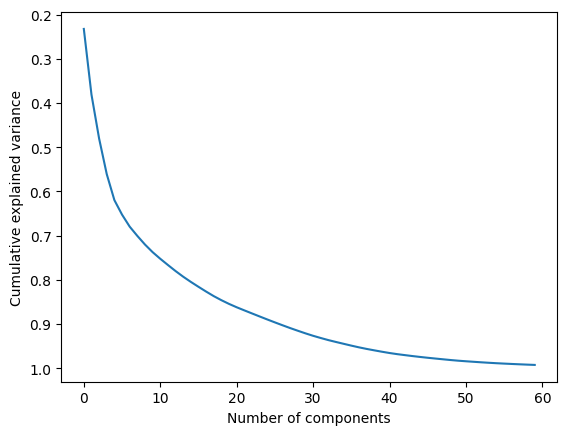

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# assume X is your data matrix with 1200 features
pca = PCA(n_components=60)
pca.fit(scaled_processedColumns)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.gca().invert_yaxis()
plt.show()
